In [1]:
import os
import numpy as np
import mne
from mne.preprocessing import *
from neurodsp.rhythm import compute_lagged_coherence
sample_data_raw_file = "./CHIMIC_EEG_DATA.edf"
raw = mne.io.read_raw_edf(sample_data_raw_file)
#raw.crop(0, 60).load_data()  # just use a fraction of data for speed here

Extracting EDF parameters from /home/ssack/An-EEGcelent-MRIgmarole/A_EEGer_Beaver/ETL_EDA_EGGposingdata/CHIMIC_EEG_DATA.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [2]:
t_start =  10
t_stop = int(t_start + (60 * 50))
channels = mne.pick_types(raw.info, meg=False, eeg=True)
# Initialize output variables
f_range = (5, 25, 0.25)
max_freq = np.zeros(32)
max_score = np.zeros(len(raw.ch_names))

# Loop lagged coherence across each channel
for ind, ch_label in enumerate(raw.ch_names):

    # Extract current channel data
    cur_sig = np.squeeze(raw.get_data(mne.pick_channels(raw.ch_names, [ch_label]),
                                      start=t_start, stop=t_stop))

    # Calculate lagged coherence on current channel data
    cur_lcs, cur_freqs = compute_lagged_coherence(cur_sig, 50, f_range, return_spectrum=True)

    # Collect data of interest: frequency of max rhythmicity & associated rhythmicity value
    max_freq[ind] = cur_freqs[np.argmax(cur_lcs)]
    max_score[ind] = np.max(cur_lcs)

In [3]:
from mne.viz import *
from matplotlib import cm, colors
vmin, vmax = 0, 0.5
raw = mne.io.read_raw_edf(sample_data_raw_file)
#plot_topomap(max_score, raw.info, cmap=cm.viridis, vmin=vmin, vmax=vmax, contours=0)


Extracting EDF parameters from /home/ssack/An-EEGcelent-MRIgmarole/A_EEGer_Beaver/ETL_EDA_EGGposingdata/CHIMIC_EEG_DATA.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [4]:
"""

mne.viz.set_3d_backend("notebook")
fig = plot_alignment(raw.info,  subject='sample', dig=False,
                     eeg=['original'], meg=[],
                     coord_frame='head')
            """
# Set viewing angle
#set_3d_view(figure=fig, azimuth=135, elevation=80)

'\n\nmne.viz.set_3d_backend("notebook")\nfig = plot_alignment(raw.info,  subject=\'sample\', dig=False,\n                     eeg=[\'original\'], meg=[],\n                     coord_frame=\'head\')\n            '

# What are artifacts?

 Artifacts are parts of the recorded signal that arise from sources other than
 the source of interest (i.e., neuronal activity in the brain). As such,
 artifacts are a form of interference or noise relative to the signal of
 interest. There are many possible causes of such interference, for example:

## - Environmental artifacts
     - Persistent oscillations centered around the `AC power line frequency`_
       (typically 50 or 60 Hz)
     - Brief signal jumps due to building vibration (such as a door slamming)
     - Electromagnetic field noise from nearby elevators, cell phones, the
       geomagnetic field, etc.

## - Instrumentation artifacts
     - Electromagnetic interference from stimulus presentation (such as EEG
       sensors picking up the field generated by unshielded headphones)
     - Continuous oscillations at specific frequencies used by head position
       indicator (HPI) coils
     - Random high-amplitude fluctuations (or alternatively, constant zero
       signal) in a single channel due to sensor malfunction (e.g., in surface
       electrodes, poor scalp contact)

## - Biological artifacts
     - Periodic `QRS`_-like signal patterns (especially in magnetometer
       channels) due to electrical activity of the heart
     - Short step-like deflections (especially in frontal EEG channels) due to
       eye movements
     - Large transient deflections (especially in frontal EEG channels) due to
       blinking
     - Brief bursts of high frequency fluctuations across several channels due
       to the muscular activity during swallowing

 There are also some cases where signals from within the brain can be
 considered artifactual. For example, if a researcher is primarily interested
 in the sensory response to a stimulus, but the experimental paradigm involves
 a behavioral response (such as button press), the neural activity associated
 with the planning and executing the button press could be considered an
 artifact relative to signal of interest (i.e., the evoked sensory response).


In [5]:
ssp_projectors = raw.info['projs']
raw.del_proj()

# %%
# Low-frequency drifts
# ~~~~~~~~~~~~~~~~~~~~
#
# Low-frequency drifts are most readily detected by visual inspection using the
# basic :meth:`~mne.io.Raw.plot` method, though it is helpful to plot a
# relatively long time span and to disable channel-wise DC shift correction.
# Here we plot 60 seconds and show all the magnetometer channels:



<RawEDF | CHIMIC_EEG_DATA.edf, 32 x 603000 (2412.0 s), ~35 kB, data not loaded>

Effective window size : 8.192 (s)


/tmp/ipykernel_18904/332070560.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)


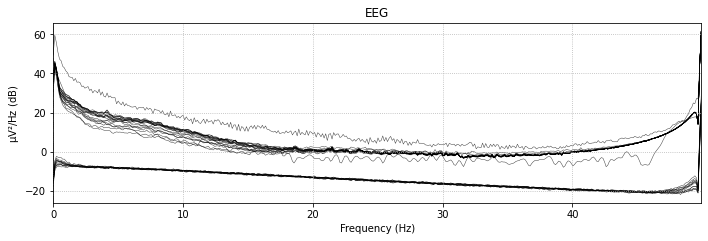

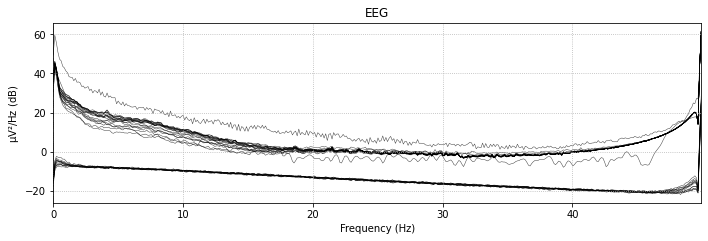

In [6]:
channels = mne.pick_types(raw.info, meg=False, eeg=True)
raw.plot_psd(fmax=50)

Using matplotlib as 2D backend.


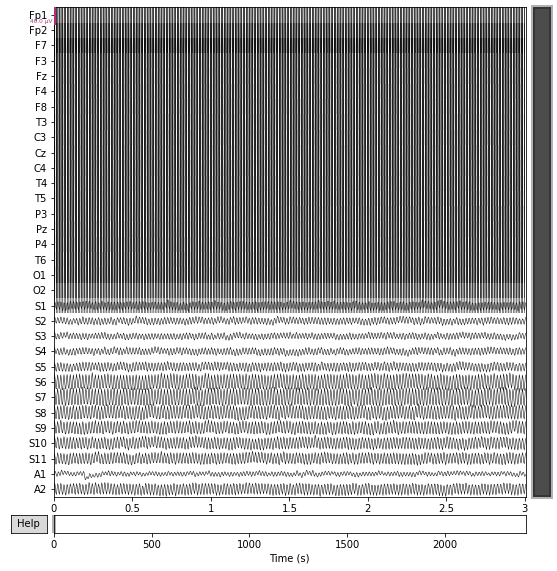

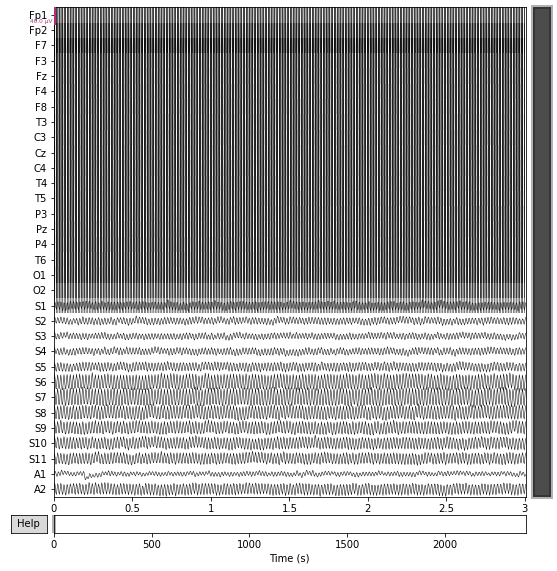

In [7]:

raw.plot(duration=3, order=channels, n_channels=32)

In [17]:
# set up and fit the ICA
filt_raw = raw.copy().filter(l_freq=1., h_freq=None)
ica = ICA(n_components=15, max_iter='auto', random_state=97)
ica.fit(filt_raw.load_data())
ica

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 16.7s.


<ICA | raw data decomposition, method: fastica (fit in 51 iterations on 603000 samples), 15 ICA components explaining 100.0 % of variance (32 PCA components available), channel types: eeg, no sources marked for exclusion>

In [ ]:

epochTime = [4*60+59 5*60 + 4,
    6*60+32,6*60+40,
    2*60+18 2*60+22,
    8 15]

In [9]:
mne.find_events(raw, stim_channel='A1', verbose=True)

array([], shape=(0, 3), dtype=int32)

In [10]:
sample_data_raw_file = "./CHIMIC_EEG_DATA.edf"
raw = mne.io.read_raw_edf(sample_data_raw_file)

Extracting EDF parameters from /home/ssack/An-EEGcelent-MRIgmarole/A_EEGer_Beaver/ETL_EDA_EGGposingdata/CHIMIC_EEG_DATA.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [11]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

Reading 0 ... 602999  =      0.000 ...  2411.996 secs...


AttributeError: module 'mne.viz.ica' has no attribute 'plot_sources'

In [12]:
raw.filter(1., None, n_jobs=1, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)



<RawEDF | CHIMIC_EEG_DATA.edf, 32 x 603000 (2412.0 s), ~147.3 MB, data loaded>

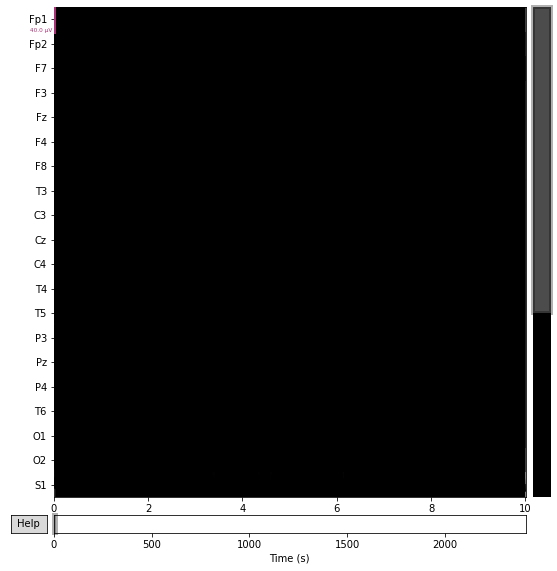

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 25 components


/tmp/ipykernel_18904/308639823.py:2: RuntimeWarning: Using n_components=25 (resulting in n_components_=25) may lead to an unstable mixing matrix estimation because the ratio between the largest (32) and smallest (1.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 21
  ica = ICA(n_components=25, method='fastica', random_state=23).fit(raw)


Fitting ICA took 19.2s.
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components


In [13]:
raw.plot();
ica = ICA(n_components=25, method='fastica', random_state=23).fit(raw)
ica.exclude = [1]
raw_clean = ica.apply(raw.copy())

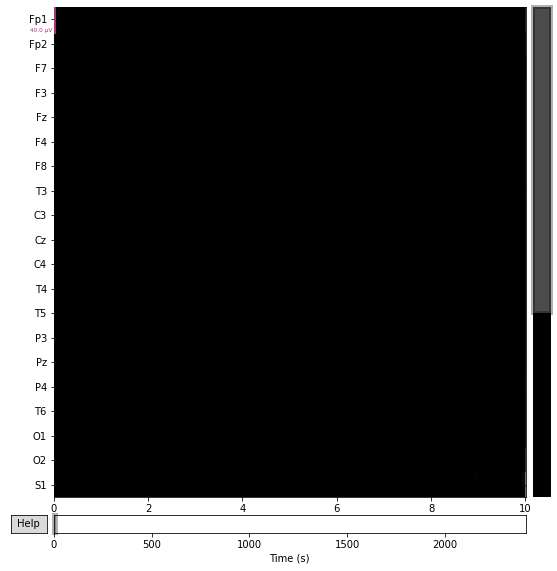

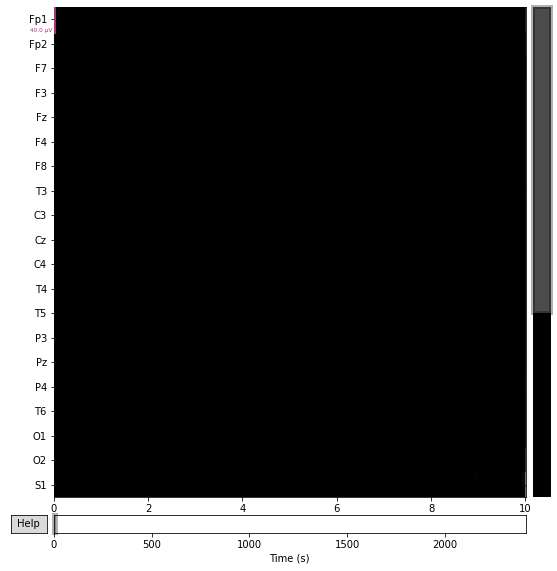

In [14]:
raw_clean.plot()

Effective window size : 8.192 (s)


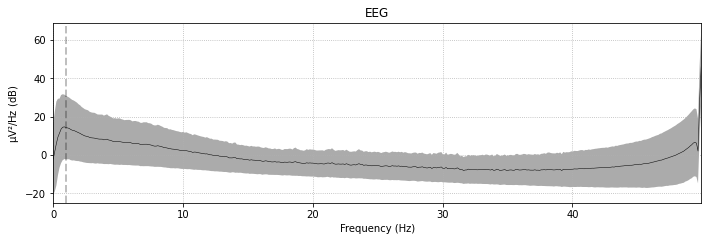

In [15]:

# %%
# Low-frequency drifts are readily removed by high-pass filtering at a fairly
# low cutoff frequency (the wavelength of the drifts seen above is probably
# around 20 seconds, so in this case a cutoff of 0.1 Hz would probably suppress
# most of the drift).
#
#
# Power line noise
# ~~~~~~~~~~~~~~~~
#
# Power line artifacts are easiest to see on plots of the spectrum, so we'll
# use :meth:`~mne.io.Raw.plot_psd` to illustrate.

fig = raw.plot_psd(tmax=np.inf, fmax=50, average=True)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)


In [16]:




# %%
# Here we see narrow frequency peaks at 60, 120, 180, and 240 Hz — the power
# line frequency of the USA (where the sample data was recorded) and its 2nd,
# 3rd, and 4th harmonics. Other peaks (around 25 to 30 Hz, and the second
# harmonic of those) are probably related to the heartbeat, which is more
# easily seen in the time domain using a dedicated heartbeat detection function
# as described in the next section.
#
#
# Heartbeat artifacts (ECG)
# ~~~~~~~~~~~~~~~~~~~~~~~~~
#
# MNE-Python includes a dedicated function
# :func:`~mne.preprocessing.find_ecg_events` in the :mod:`mne.preprocessing`
# submodule, for detecting heartbeat artifacts from either dedicated ECG
# channels or from magnetometers (if no ECG channel is present). Additionally,
# the function :func:`~mne.preprocessing.create_ecg_epochs` will call
# :func:`~mne.preprocessing.find_ecg_events` under the hood, and use the
# resulting events array to extract epochs centered around the detected
# heartbeat artifacts. Here we create those epochs, then show an image plot of
# the detected ECG artifacts along with the average ERF across artifacts. We'll
# show all three channel types, even though EEG channels are less strongly
# affected by heartbeat artifacts:

# sphinx_gallery_thumbnail_number = 4
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
ecg_epochs.plot_image(combine='mean')

# %%
# The horizontal streaks in the magnetometer image plot reflect the fact that
# the heartbeat artifacts are superimposed on low-frequency drifts like the one
# we saw in an earlier section; to avoid this you could pass
# ``baseline=(-0.5, -0.2)`` in the call to
# :func:`~mne.preprocessing.create_ecg_epochs`.
# You can also get a quick look at the
# ECG-related field pattern across sensors by averaging the ECG epochs together
# via the :meth:`~mne.Epochs.average` method, and then using the
# :meth:`mne.Evoked.plot_topomap` method:

avg_ecg_epochs = ecg_epochs.average().apply_baseline((-0.5, -0.2))

# %%
# Here again we can visualize the spatial pattern of the associated field at
# various times relative to the peak of the EOG response:

avg_ecg_epochs.plot_topomap(times=np.linspace(-0.05, 0.05, 11))

# %%
# Or, we can get an ERP/F plot with :meth:`~mne.Evoked.plot` or a combined
# scalp field maps and ERP/F plot with :meth:`~mne.Evoked.plot_joint`. Here
# we've specified the times for scalp field maps manually, but if not provided
# they will be chosen automatically based on peaks in the signal:

avg_ecg_epochs.plot_joint(times=[-0.25, -0.025, 0, 0.025, 0.25])

# %%
# Ocular artifacts (EOG)
# ~~~~~~~~~~~~~~~~~~~~~~
#
# Similar to the ECG detection and epoching methods described above, MNE-Python
# also includes functions for detecting and extracting ocular artifacts:
# :func:`~mne.preprocessing.find_eog_events` and
# :func:`~mne.preprocessing.create_eog_epochs`. Once again we'll use the
# higher-level convenience function that automatically finds the artifacts and
# extracts them in to an :class:`~mne.Epochs` object in one step. Unlike the
# heartbeat artifacts seen above, ocular artifacts are usually most prominent
# in the EEG channels, but we'll still show all three channel types. We'll use
# the ``baseline`` parameter this time too; note that there are many fewer
# blinks than heartbeats, which makes the image plots appear somewhat blocky:

eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
eog_epochs.plot_image(combine='mean')
eog_epochs.average().plot_joint()

# %%
# Summary
# ^^^^^^^
#
# Familiarizing yourself with typical artifact patterns and magnitudes is a
# crucial first step in assessing the efficacy of later attempts to repair
# those artifacts. A good rule of thumb is that the artifact amplitudes should
# be orders of magnitude larger than your signal of interest — and there should
# be several occurrences of such events — in order to find signal
# decompositions that effectively estimate and repair the artifacts.
#
# Several other tutorials in this section illustrate the various tools for
# artifact repair, and discuss the pros and cons of each technique, for
# example:
#
# - :ref:`tut-artifact-ssp`
# - :ref:`tut-artifact-ica`
# - :ref:`tut-artifact-sss`
#
# There are also tutorials on general-purpose preprocessing steps such as
# :ref:`filtering and resampling <tut-filter-resample>` and :ref:`excluding
# bad channels <tut-bad-channels>` or :ref:`spans of data
# <tut-reject-data-spans>`.
#
# .. LINKS
#
# .. _`AC power line frequency`:
#    https://en.wikipedia.org/wiki/Mains_electricity
# .. _`QRS`: https://en.wikipedia.org/wiki/QRS_complex
# .. _`memory-mapped`: https://en.wikipedia.org/wiki/Memory-mapped_file


ValueError: Unable to generate artificial ECG channel